In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


import gc


df = pd.read_csv('./output/train.csv')


In [2]:
df.isna().sum(axis=1)
print(len(df))
df = df.dropna(axis=0)
print(len(df))

# no games from 2011 bc they have nans
with pd.option_context('mode.use_inf_as_na', True):
    df = df.fillna(0)
    

106368
84568


In [3]:

print(df.shape)

(84568, 57)


In [4]:
to_drop = ['Sea_TO_x','Sea_TO_y','Sea_FT_x','Sea_FT_y','Sea_PF_x','Sea_PF_y']

df = df.drop(columns=to_drop)

y = df.target
X = df.drop(columns=['target'])

In [5]:
scaler = StandardScaler()
cat = []
num = [i for i in list(df)]

df[num] = scaler.fit_transform(df[num])

In [6]:


# using LGBM gain
# to_drop = ['Sea_FT_x','Sea_FT_y','wSea_OReb_x','wSea_OReb_y','wSea_2pt_x','wSea_2pt_y','wSea_3pt_x','wSea_3pt_y']
# X = X.drop(columns=to_drop)


In [7]:
from lofo import LOFOImportance, Dataset, plot_importance

# extract a sample of the data
sample_df = df.sample(frac=1, random_state=0)

# define the validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=0)

dataset = Dataset(df=sample_df, target="target", features=[col for col in df.columns if col != "target"])

In [8]:
# model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')

# # define the validation scheme and scorer. The default model is LightGBM
# lofo_imp = LOFOImportance(dataset, model= model_lgb, cv=cv, scoring="neg_mean_absolute_error")

# # get the mean and standard deviation of the importances in pandas format
# importance_df = lofo_imp.get_importance()

# # plot the means and standard deviations of the importances
# # plot_importance(importance_df, figsize=(12, 20))


In [9]:
# figsize = (12,20)
# importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
# importance_df.sort_values("importance_mean", inplace=True)
# importance_df.plot(x="feature", y="importance_mean", xerr="importance_std", kind='barh', color=importance_df["color"], figsize=figsize)
# plt.tight_layout()
# plt.savefig('./figures/lofo_importance4.png')


In [10]:


# colormap = plt.cm.RdBu
# plt.figure(figsize=(14,14))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True, cmap=colormap, linecolor='white', annot=False)



In [11]:
n_folds = 5
feat_names = list(X)

def mae_cv(model, lin_reg=False):

    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X.values)
    output = cross_validate(model, X.values, y, cv=kf, scoring = 'neg_mean_absolute_error', return_estimator=True)
    all_estimators = []
    for idx,estimator in enumerate(output['estimator']):
        if lin_reg:
            all_estimators.append(list(estimator.coef_))
        else:  
            all_estimators.append(list(estimator.feature_importances_))
    
    all_estimators = pd.DataFrame(all_estimators)
    avg_imp = all_estimators.values.mean(axis=0)
    feature_importances = pd.DataFrame(avg_imp, index = feat_names,
                                       columns=['importance']).sort_values('importance', ascending=False).reset_index()
    
    feature_importances.columns = ['feats','importance']
    return output, feature_importances


Lin_Reg score: 9.1749 (0.1207)



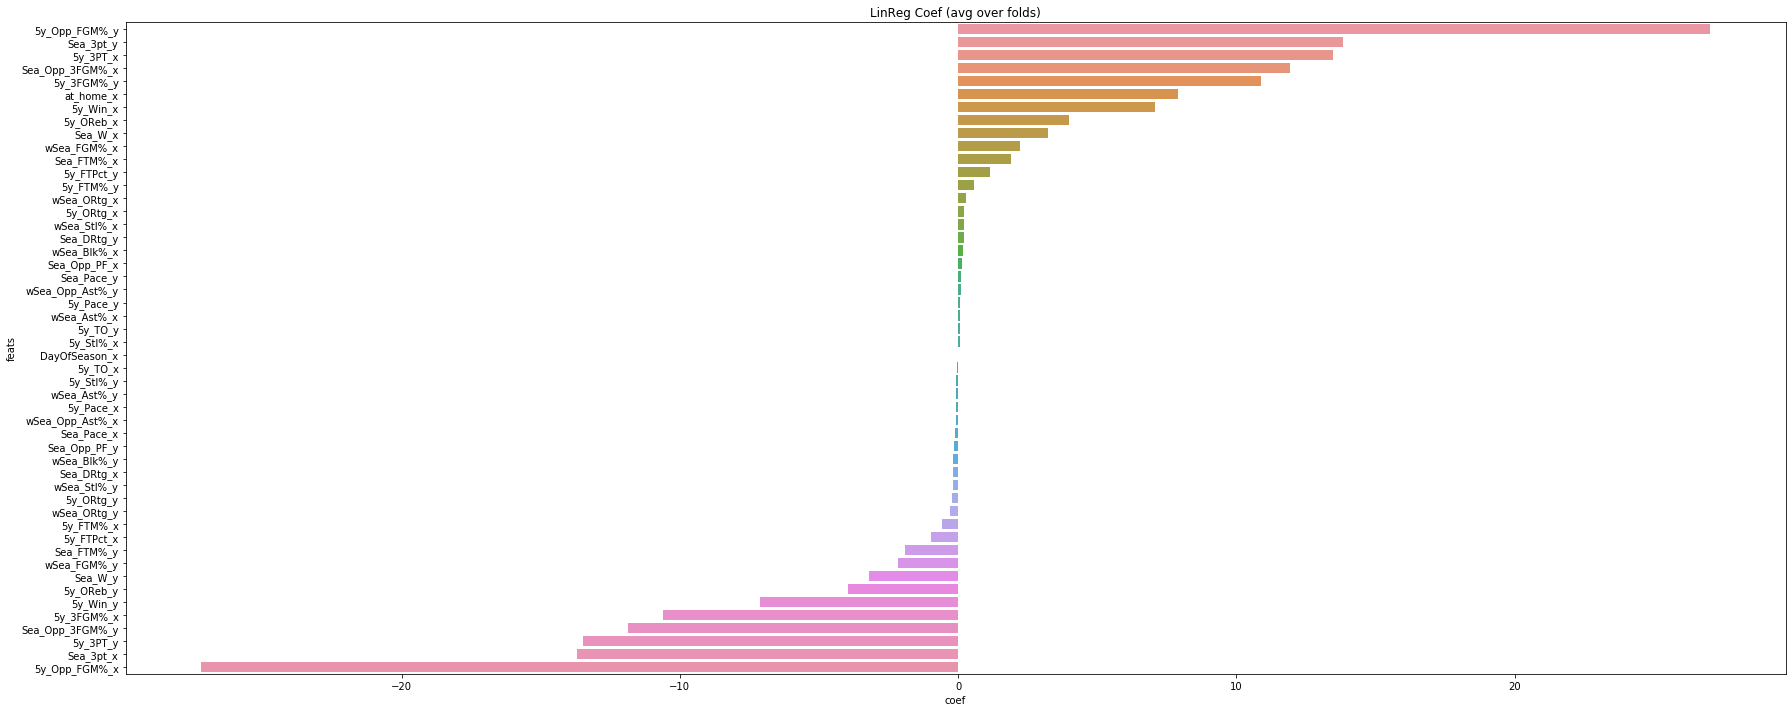

In [12]:
lin_reg = LinearRegression()

output, feat_imp = mae_cv(lin_reg, lin_reg=True)
print("Lin_Reg score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))
# print(output['test_score'])
plt.figure(figsize=(25, 10))

sns.barplot(x="importance", y="feats", data=feat_imp)
plt.title('LinReg Coef (avg over folds)')
plt.xlabel('coef')
plt.tight_layout()
plt.savefig('./figures/linreg_importances-03.png')
plt.show()

In [13]:
# score = mae_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')
output, feat_imp = mae_cv(model_lgb)
# dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])



# rekord 
# LGBM score: 9.0919 (0.1094)


print("LGBM score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))

plt.figure(figsize=(25, 10))
sns.barplot(x="importance", y="feats", data=feat_imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('./figures/lgbm_importances-03.png')
plt.show()


In [ ]:
print(list(feat_imp.feats))


# Now for neural network


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# def get_model():
#     x = keras.layers.Input(shape=[X.shape[1]])
#     fc1 = keras.layers.Dense(units=450, input_shape=[X.shape[1]])(x)
#     act1 = keras.layers.PReLU()(fc1)
#     bn1 = keras.layers.BatchNormalization()(act1)
#     dp1 = keras.layers.Dropout(0.45)(bn1)
#     gn1 = keras.layers.GaussianNoise(0.15)(dp1)
#     concat1 = keras.layers.Concatenate()([x, gn1])
#     fc2 = keras.layers.Dense(units=600)(concat1)
#     act2 = keras.layers.PReLU()(fc2)
#     bn2 = keras.layers.BatchNormalization()(act2)
#     dp2 = keras.layers.Dropout(0.45)(bn2)
#     gn2 = keras.layers.GaussianNoise(0.15)(dp2)
#     concat2 = keras.layers.Concatenate()([concat1, gn2])
#     fc3 = keras.layers.Dense(units=400)(concat2)
#     act3 = keras.layers.PReLU()(fc3)
#     bn3 = keras.layers.BatchNormalization()(act3)
#     dp3 = keras.layers.Dropout(0.45)(bn3)
#     gn3 = keras.layers.GaussianNoise(0.15)(dp3)
#     concat3 = keras.layers.Concatenate([concat2, gn3])
#     output = keras.layers.Dense(units=1)(concat2)
#     model = keras.models.Model(inputs=[x], outputs=[output])
#     return model

def get_model():
    # define the keras model
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

model = get_model()

In [ ]:



def train_model(X_train, y_train, X_val, y_val):
    model = get_model()
    model.compile(optimizer='adam', loss='mean_absolute_error')
    er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=batch_size)
    return model


In [ ]:
X = X.values
y = y.values


In [ ]:
X.shape

In [ ]:

rkf = RepeatedKFold(n_splits=5, n_repeats=5)
batch_size = 64
models = []

for tr_idx, vl_idx in rkf.split(X, y):
    
    x_tr, y_tr = X[tr_idx], y[tr_idx]
    x_vl, y_vl = X[vl_idx], y[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='./figures/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
val_losses = []
for model in models:
    val_losses.append(np.min(model.history.history['val_loss']))

print(np.mean(val_losses))